<a href="https://colab.research.google.com/github/ismat210/Sentiment-Analysis-of-Text-Data-/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset


Import required libraries

In [5]:
!pip install transformers datasets torch pandas matplotlib --quiet
!pip install scikit-learn --quiet


Load the IMDB dataset ----Each row contains:

text: movie review

label: 0 = negative, 1 = positive

In [7]:
# Load IMDB movie reviews dataset
dataset = load_dataset("imdb")

# Convert to pandas DataFrame
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Preview data
train_df.head()


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


Quick exploration (EDA)

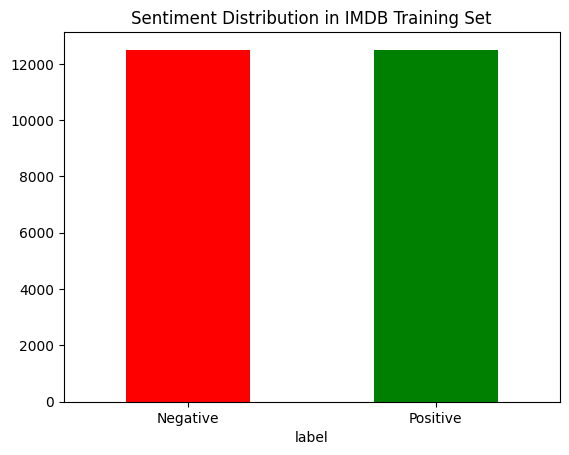

In [8]:
# Distribution of sentiment labels
train_df['label'].value_counts().plot(kind='bar', color=['red','green'])
plt.xticks([0,1], ['Negative', 'Positive'], rotation=0)
plt.title("Sentiment Distribution in IMDB Training Set")
plt.show()


 Load pre-trained sentiment analysis model

In [17]:
from transformers import pipeline

# Load the sentiment-analysis pipeline with truncation
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english"
)

# Apply with truncation to each text
subset['predicted_sentiment'] = subset['text'].apply(
    lambda x: sentiment_analyzer(x, truncation=True, max_length=512)[0]['label']
)
subset['confidence'] = subset['text'].apply(
    lambda x: sentiment_analyzer(x, truncation=True, max_length=512)[0]['score']
)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Test sentiment analyzer on sample reviews

In [10]:
sample_reviews = train_df['text'][:5]
for review in sample_reviews:
    result = sentiment_analyzer(review)[0]
    print(f"Review: {review[:100]}...")
    print(f"Predicted: {result['label']}, Confidence: {result['score']:.2f}\n")



Review: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Predicted: POSITIVE, Confidence: 0.79

Review: "I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's poli...
Predicted: NEGATIVE, Confidence: 1.00

Review: If only to avoid making this type of film in the future. This film is interesting as an experiment b...
Predicted: NEGATIVE, Confidence: 1.00

Review: This film was probably inspired by Godard's Masculin, féminin and I urge you to see that film instea...
Predicted: POSITIVE, Confidence: 0.81

Review: Oh, brother...after hearing about this ridiculous film for umpteen years all I can think of is that ...
Predicted: NEGATIVE, Confidence: 1.00



Apply model to a subset of dataset

In [18]:
subset = train_df.sample(500, random_state=42)

# Apply sentiment analysis safely
subset['predicted_sentiment'] = subset['text'].apply(
    lambda x: sentiment_analyzer(x[:512])[0]['label']
)
subset['confidence'] = subset['text'].apply(
    lambda x: sentiment_analyzer(x[:512])[0]['score']
)

subset.head()


,text,label,predicted_sentiment,confidence
6868,"Dumb is as dumb does, in this thoroughly unint...",0,NEGATIVE,0.999364
24016,I dug out from my garage some old musicals and...,1,POSITIVE,0.998441
9668,After watching this movie I was honestly disap...,0,NEGATIVE,0.973757
13640,This movie was nominated for best picture but ...,1,NEGATIVE,0.997983
14018,Just like Al Gore shook us up with his painful...,1,POSITIVE,0.990984


Compare predictions with actual labels

In [20]:
# Map predicted labels to numeric
label_map = {"NEGATIVE": 0, "POSITIVE": 1}
subset['predicted_numeric'] = subset['predicted_sentiment'].map(label_map)

# Now compute accuracy
y_true = subset['label']
y_pred = subset['predicted_numeric']

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.834

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       266
           1       0.85      0.79      0.82       234

    accuracy                           0.83       500
   macro avg       0.84      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



 Visualize predicted sentiment

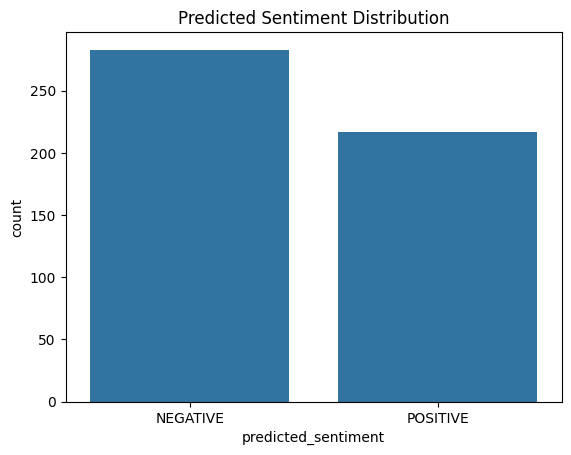

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=subset, x='predicted_sentiment')
plt.title("Predicted Sentiment Distribution")
plt.show()


Confusion Matrix

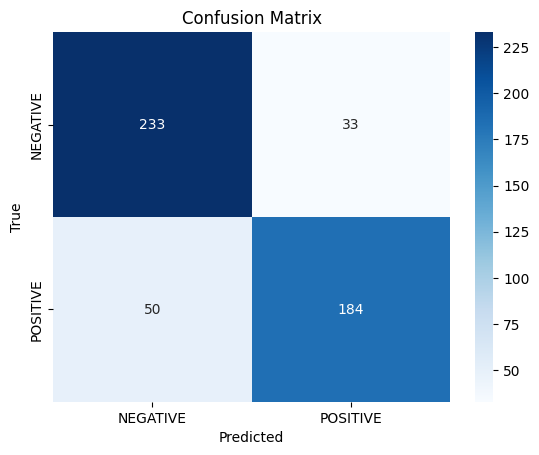

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# --- Make labels consistent ---
label_map = {"NEGATIVE": 0, "POSITIVE": 1}
subset['predicted_numeric'] = subset['predicted_sentiment'].map(label_map)

y_true = subset['label']
y_pred = subset['predicted_numeric']

# --- Compute confusion matrix ---
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

# --- Plot confusion matrix using seaborn ---
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NEGATIVE", "POSITIVE"],
            yticklabels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
